In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../")

In [3]:
from tokenizers import Tokenizer
import sys

import matplotlib.pyplot as plt
import numpy as np
import collections
import torch

from ChEmbed.data import chembldb, smiles_dataset, chembed_tokenize
from ChEmbed.training import trainer
from ChEmbed.modules import simple_rnn

from ChEmbed import plots, utilities

Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.0
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [4]:
chembl_raw = chembldb.ChemblDB()
chembl_smiles = chembl_raw._load_or_download()["canonical_smiles"]

In [5]:
tokenizer = chembed_tokenize.load_chembed_tokenizer(filepath = "../data/tokenizers/tokenizer-chembldb-16-06-2025.json")

In [23]:
# chembl_dataset = smiles_dataset.SMILESDataset(
#     smiles_list = chembl_smiles,
#     tokenizer = tokenizer
# )

chembl_mini = smiles_dataset.SMILESDataset(
    smiles_list = chembl_smiles[:1000],
    tokenizer = tokenizer
)

In [24]:
model = simple_rnn.simpleRNN(
    # Mandatory
    num_hiddens = 128,
    vocab_size = len(tokenizer),
    # tuning
    learning_rate = 0.01,
    weight_decay = 0.02
)

In [25]:
model.initialize_parameters(model)

In [26]:
def predict(input, num_preds, model, dataset, device=None):
    state, outputs = None, [input[0]]

    # predict input + num_preds tokens
    for i in range(len(input) + num_preds - 1):
        
        X = torch.tensor(dataset.encode_smiles_to_one_hot(outputs[i]), device=device)
        
        rnn_outputs, state = model.rnn(X, state)

        if i < len(input) - 1:
            outputs.append(input[i + 1])
        else:
            tokens = model.linear(rnn_outputs).argmax().tolist()
            Y = dataset.tokenizer.decode(tokens)
            outputs.append(Y)

    return ''.join(outputs)
            

In [27]:
print(predict("CCC", 30, model, chembl_mini, device="cpu"))

CCCCN1CC23CCN1CC23CCN1CC23CCN1CC23C


/tmp/ipykernel_13185/2808148441.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(dataset.encode_smiles_to_one_hot(outputs[i]), device=device)


In [28]:
model_trainer = trainer.Trainer(max_epochs=16, init_random=None)
model_trainer.fit(model, chembl_mini)

Epoch 16/16: Train Loss: 0.6124, Val Loss: 0.6064


In [29]:
print(predict("C=", 15, model, chembl_mini, device="cuda"))

C=CCCCCCC


/tmp/ipykernel_13185/2808148441.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(dataset.encode_smiles_to_one_hot(outputs[i]), device=device)


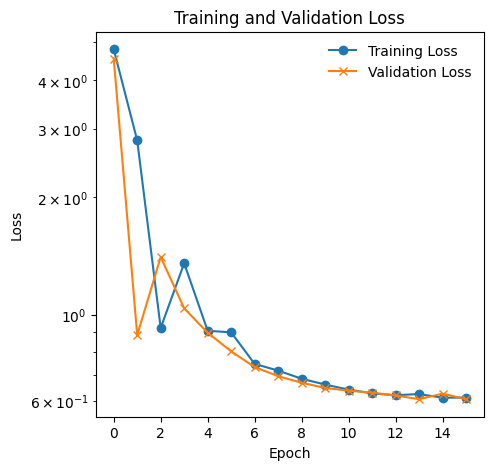

In [30]:
losses = utilities.extract_training_losses(model_trainer.metadata)
fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
ax.set_yscale('log')